## Fraud Order Clustering

### Import libraries and data

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [86]:
df = pd.read_csv("/Users/kaopeimin/Documents/McGill/Course/INSY695/group project/DataCoSupplyChainDataset.csv", encoding='latin1')
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


### Data preprocessing

In [87]:
# filter order status with "SUSPECTED_FRAUD" to proceed following clustering
data = df[df['Order Status'] == "SUSPECTED_FRAUD"]
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
10,TRANSFER,6,2,130.580002,272.029999,Shipping canceled,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/19/2018 9:18,Second Class
24,TRANSFER,2,2,90.279999,288.420013,Shipping canceled,0,73,Sporting Goods,Billings,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.750000,0,1/15/2018 4:24,Second Class
183,TRANSFER,5,4,28.850000,128.220001,Shipping canceled,0,13,Electronics,Freeport,...,77041.0,278,13,NaN,http://images.acmesports.sports/Under+Armour+M...,Under Armour Men's Compression EV SL Slide,44.990002,0,5/13/2016 17:42,Standard Class
184,TRANSFER,5,4,133.910004,278.970001,Shipping canceled,0,9,Cardio Equipment,Fort Washington,...,85234.0,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,4/7/2016 19:51,Standard Class
185,TRANSFER,6,4,79.160004,272.970001,Shipping canceled,0,9,Cardio Equipment,Bakersfield,...,95123.0,191,9,NaN,http://images.acmesports.sports/Nike+Men%27s+F...,Nike Men's Free 5.0+ Running Shoe,99.989998,0,8/20/2016 2:51,Standard Class


In [88]:
# drop unnecessary columns
data = data.drop(['Category Id', 'Customer City', 'Customer Email', 'Customer Fname', 'Customer Id', 
                'Customer Lname', 'Customer Password', 'Customer Street', 'Customer Zipcode', 
                'Department Id', 'Order City', 'Order Customer Id', 'order date (DateOrders)',
                'Order Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Id',
                'Order State', 'Order Zipcode', 'Product Card Id', 'Product Category Id', 'Product Description',
                'Product Image', 'Product Name', 'shipping date (DateOrders)'], axis=1)
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Name,Customer Country,Customer Segment,...,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order Status,Product Price,Product Status,Shipping Mode
10,TRANSFER,6,2,130.580002,272.029999,Shipping canceled,0,Sporting Goods,Puerto Rico,Corporate,...,0.48,1,327.750000,272.029999,130.580002,Eastern Asia,SUSPECTED_FRAUD,327.750000,0,Second Class
24,TRANSFER,2,2,90.279999,288.420013,Shipping canceled,0,Sporting Goods,EE. UU.,Corporate,...,0.31,1,327.750000,288.420013,90.279999,Oceania,SUSPECTED_FRAUD,327.750000,0,Second Class
183,TRANSFER,5,4,28.850000,128.220001,Shipping canceled,0,Electronics,EE. UU.,Consumer,...,0.23,3,134.970001,128.220001,28.850000,US Center,SUSPECTED_FRAUD,44.990002,0,Standard Class
184,TRANSFER,5,4,133.910004,278.970001,Shipping canceled,0,Cardio Equipment,EE. UU.,Consumer,...,0.48,3,299.970001,278.970001,133.910004,West of USA,SUSPECTED_FRAUD,99.989998,0,Standard Class
185,TRANSFER,6,4,79.160004,272.970001,Shipping canceled,0,Cardio Equipment,EE. UU.,Consumer,...,0.29,3,299.970001,272.970001,79.160004,West of USA,SUSPECTED_FRAUD,99.989998,0,Standard Class


In [89]:
# detect unary variables
variables = {}
column_types = {}

# calculate unique values and determine column types
for column in data.columns:
    unique_values = data[column].nunique()
    variables[column] = unique_values
    column_types[column] = data[column].dtype

# sort the unary variables by the number of unique values in ascending order
sorted_variables = sorted(variables.items(), key=lambda x: x[1])

print("Variables and their unique value counts (in ascending order):")
for column, unique_count in sorted_variables:
    print(f"{column}: {unique_count}, ({column_types[column]})")


Variables and their unique value counts (in ascending order):
Type: 1, (object)
Delivery Status: 1, (object)
Late_delivery_risk: 1, (int64)
Order Status: 1, (object)
Product Status: 1, (int64)
Customer Country: 2, (object)
Customer Segment: 3, (object)
Days for shipment (scheduled): 4, (int64)
Shipping Mode: 4, (object)
Market: 5, (object)
Order Item Quantity: 5, (int64)
Days for shipping (real): 7, (int64)
Department Name: 11, (object)
Order Item Discount Rate: 18, (float64)
Order Region: 23, (object)
Customer State: 39, (object)
Category Name: 48, (object)
Order Item Product Price: 69, (float64)
Product Price: 69, (float64)
Order Country: 102, (object)
Order Item Profit Ratio: 147, (float64)
Sales: 153, (float64)
Longitude: 771, (float64)
Sales per customer: 893, (float64)
Order Item Total: 893, (float64)
Latitude: 1269, (float64)
Benefit per order: 3046, (float64)
Order Profit Per Order: 3046, (float64)


In [90]:
# delete the unary variables
data = data.drop(['Type', 'Delivery Status', 'Late_delivery_risk', 'Order Status', 'Product Status'], axis=1)

# drop those cateogrical variables with unique value higher than 10
data = data.drop(['Department Name', 'Order Item Discount Rate', 'Order Region', 'Customer State', 'Category Name', 'Order Country'], axis=1)
data.head()

# drop factors showing low variety across clusters in the experiments
data = data.drop(['Latitude', 'Longitude'], axis=1) # test 1
data = data.drop(['Customer Country', 'Customer Segment', 'Market'], axis=1) # test 2

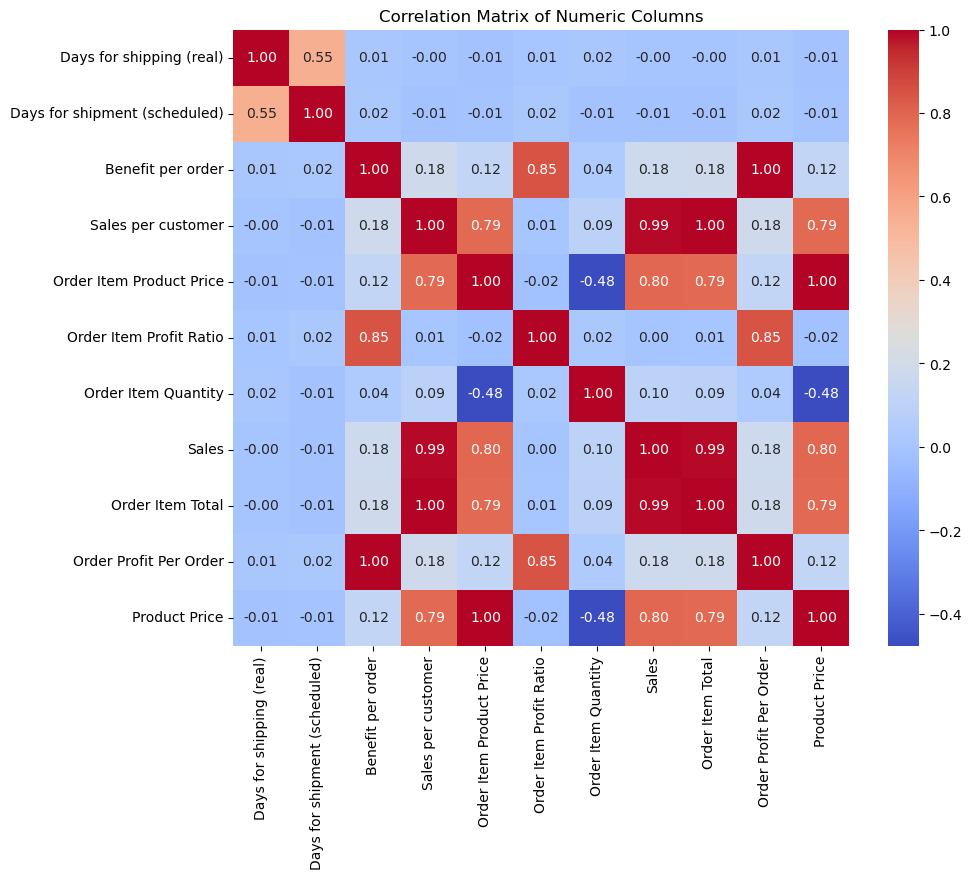

In [91]:
numeric_columns = data.select_dtypes(include=['number'])

# calculate the correlation matrix
corr_matrix = numeric_columns.corr()
corr_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()


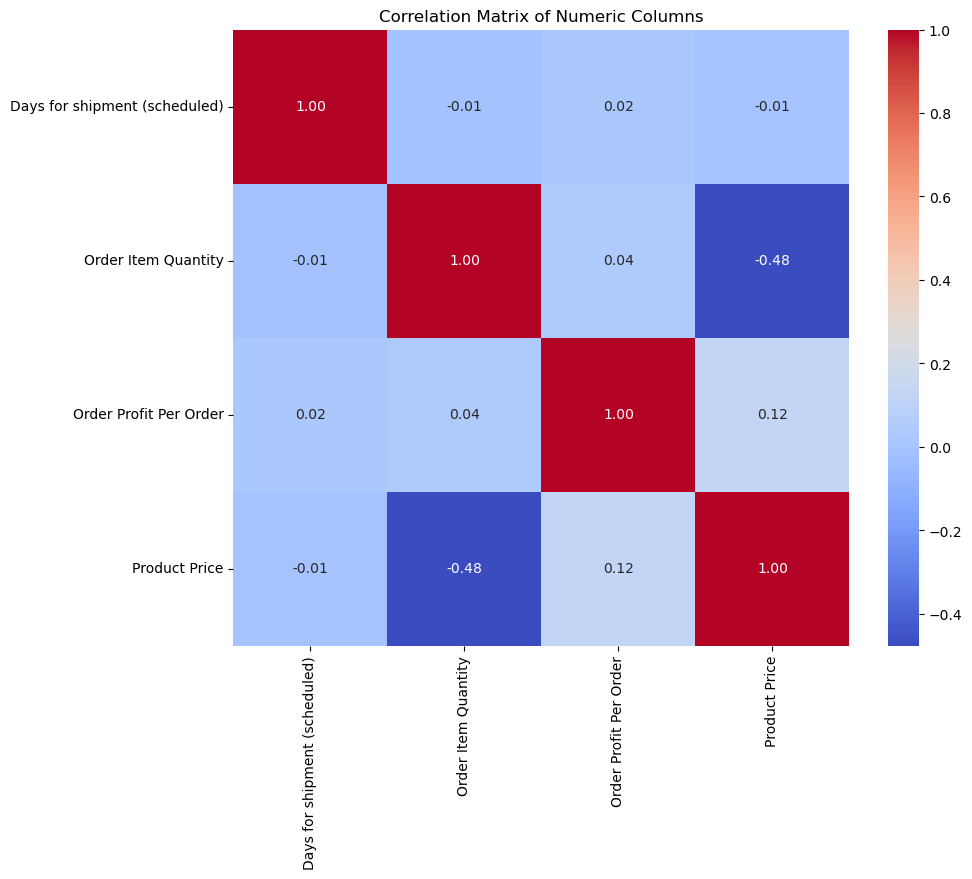

In [92]:
# drop correlational features
data = data.drop(['Days for shipping (real)', 'Benefit per order', 'Order Item Product Price', 'Order Item Profit Ratio',
                  'Sales per customer', 'Order Item Total', 'Sales'], axis=1)

# check correlation matrix again
numeric_columns = data.select_dtypes(include=['number'])

# calculate the correlation matrix
corr_matrix = numeric_columns.corr()
corr_matrix

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

# final numeric variables - Days for shipment (scheduled), Order Item Quantity, Order Profit Per Order, Product Price

### K-Means

In [93]:
X = data

# define preprocessing steps for numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# model pipeline
kmeans = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('KMeans', KMeans(n_clusters=8, random_state=0))
])

kmeans.fit_transform(X)

# retrieve cluster centroids from the KMeans estimator
cluster_centers = kmeans.named_steps['KMeans'].cluster_centers_

# getting feature names after one-hot encoding
one_hot_columns = kmeans.named_steps['preprocessor']\
                            .named_transformers_['cat']\
                            .named_steps['onehot']\
                            .categories_

# combine feature names from numeric and one-hot encoded categorical features
columns = list(numeric_features) + [f"{cat}_{val}" for cat, vals in zip(categorical_features, one_hot_columns) for val in vals]

group = pd.DataFrame(cluster_centers, columns=columns)
print(group)

/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   Days for shipment (scheduled)  Order Item Quantity  Order Profit Per Order  \
0                       0.785451             1.293650                0.188072   
1                      -1.145019            -0.773777                0.598660   
2                       0.785451            -0.773777                0.575662   
3                       0.785451            -0.598568               -0.066328   
4                      -1.149874             1.295627                0.131093   
5                      -1.138746            -0.610181               -0.057817   
6                      -0.111862            -0.185278               -3.803041   
7                       0.131016            -0.773777                3.360236   

   Product Price  Shipping Mode_First Class  Shipping Mode_Same Day  \
0      -0.613913              -5.828671e-16            4.163336e-17   
1       1.557929               4.532872e-01            1.141869e-01   
2       1.551771              -5.551115e-17           -4.

In [94]:
# try different numbers of clusters and calculate inertia for each
cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10]
inertia_values = []

for n_clusters in cluster_numbers:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('kmeans', KMeans(n_clusters=n_clusters))
    ])

    pipeline.fit(X)

    inertia = pipeline.named_steps['kmeans'].inertia_
    inertia_values.append(inertia)
    print(f"Inertia (WCSS) for {n_clusters} clusters:", inertia)

print("\nInertia values:", inertia_values)

/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia (WCSS) for 2 clusters: 13599.341720645036
Inertia (WCSS) for 3 clusters: 10971.778660929618


/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia (WCSS) for 4 clusters: 9056.596853285726
Inertia (WCSS) for 5 clusters: 7392.2241438191795


/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia (WCSS) for 6 clusters: 6087.843137035863


/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia (WCSS) for 7 clusters: 5360.070401284849


/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia (WCSS) for 8 clusters: 4578.015265356701


/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia (WCSS) for 9 clusters: 4243.800160547903


/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia (WCSS) for 10 clusters: 3789.6846374909555

Inertia values: [13599.341720645036, 10971.778660929618, 9056.596853285726, 7392.2241438191795, 6087.843137035863, 5360.070401284849, 4578.015265356701, 4243.800160547903, 3789.6846374909555]


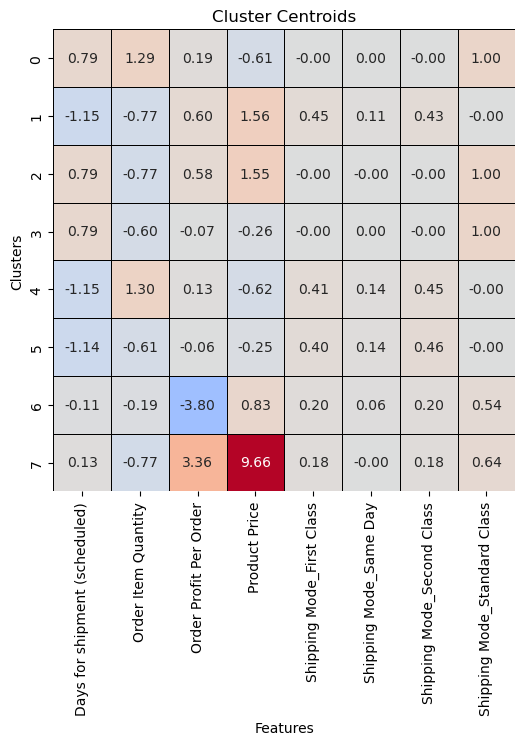

In [95]:
# plot the cluster centroids as a heatmap
palette = {0: 'red', 1: 'blue'}

plt.figure(figsize=(10, 6))
sns.heatmap(group, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, linecolor='black', cbar=False, annot_kws={"size": 10}, center=0, square=True)
plt.title('Cluster Centroids')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

#### Visualize K-Means results

In [96]:
# retrieve cluster centroids from the KMeans estimator
cluster_centers_scaled = kmeans.named_steps['KMeans'].cluster_centers_

# inverse transform the scaled centroids to get original values for numeric features
scaler = kmeans.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler']
cluster_centers_numeric = scaler.inverse_transform(cluster_centers_scaled[:, :len(numeric_features)])

# inverse transform the one-hot encoded centroids to get original values for categorical features
onehot = kmeans.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cluster_centers_categorical = onehot.inverse_transform(cluster_centers_scaled[:, len(numeric_features):])

# adjust the code to get the correct number of columns
columns = list(numeric_features) + list(onehot.get_feature_names_out(categorical_features))

# slice the categorical feature names for each category to avoid duplicates
categorical_columns = []
for cat, vals in zip(categorical_features, onehot.categories_):
    categorical_columns.extend([f"{cat}_{val}" for val in vals])

cluster_centers_combined = np.hstack((cluster_centers_numeric, cluster_centers_categorical))

cluster_centers_original = pd.DataFrame(
    data=cluster_centers_numeric,
    columns=numeric_features
)

print(cluster_centers_original)


   Days for shipment (scheduled)  Order Item Quantity  Order Profit Per Order  \
0                       4.000000             3.993515               40.210234   
1                       1.318339             1.000000               82.237751   
2                       4.000000             1.000000               79.883697   
3                       4.000000             1.253692               14.169974   
4                       1.311594             3.996377               34.377899   
5                       1.327052             1.236878               15.041184   
6                       2.753521             1.852113             -368.317465   
7                       3.090909             1.000000              364.910911   

   Product Price  
0      55.297821  
1     360.687761  
2     359.821847  
3     105.013044  
4      54.303533  
5     106.757567  
6     258.599514  
7    1500.000000  


In [97]:
print("Shape of cluster_centers_categorical:\n", cluster_centers_categorical)

Shape of cluster_centers_categorical:
 [['Standard Class']
 ['First Class']
 ['Standard Class']
 ['Standard Class']
 ['Second Class']
 ['Second Class']
 ['Standard Class']
 ['Standard Class']]


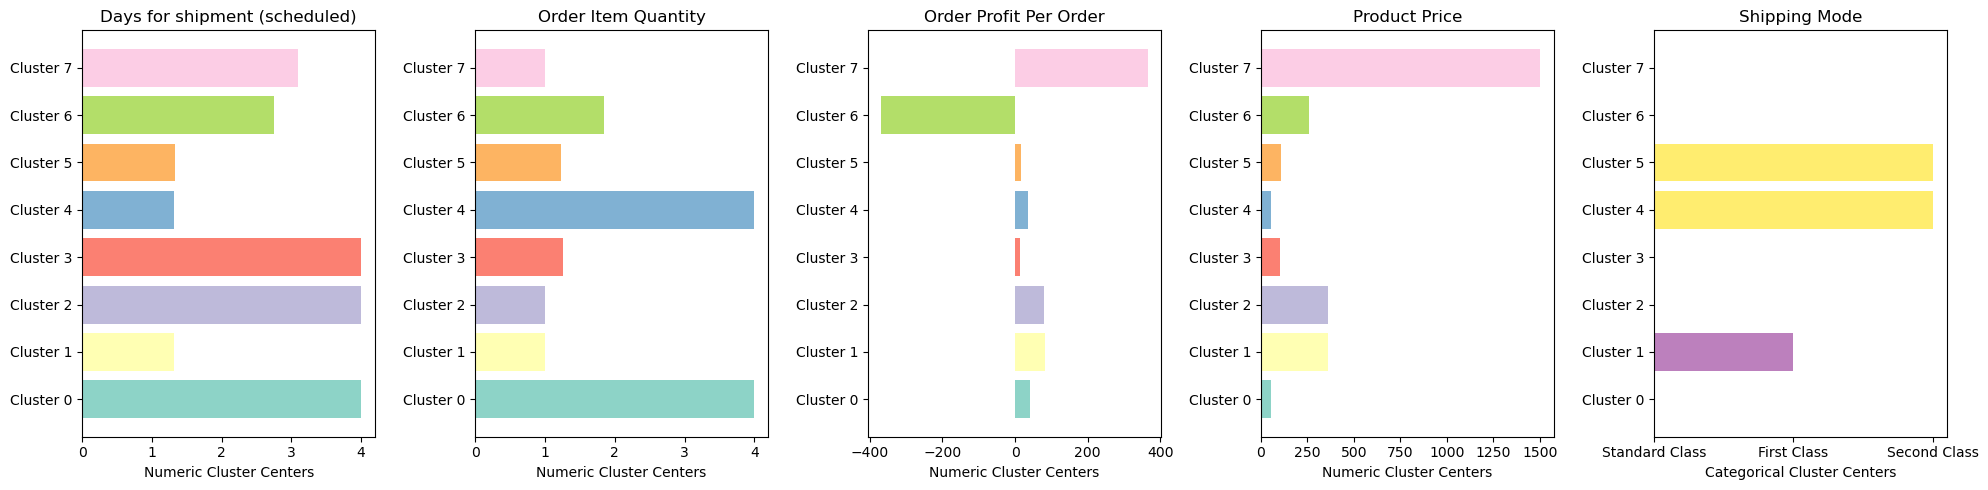

In [98]:
# define a color palette with different colors for each cluster
colors = plt.cm.Set3(np.arange(len(cluster_centers_numeric) + len(cluster_centers_categorical)))

# define the number of rows and columns for subplots
n_rows = 1
n_cols = len(numeric_features) + len(categorical_features)

# set up the subplot grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5))

for i, feature in enumerate(numeric_features):
    for j in range(len(cluster_centers_numeric)):
        axes[i].barh(j, cluster_centers_numeric[j, i], color=colors[j], label=f'Numeric - Cluster {j}')
    axes[i].set_yticks(range(len(cluster_centers_numeric)))
    axes[i].set_yticklabels([f'Cluster {j}' for j in range(len(cluster_centers_numeric))])
    axes[i].set_xlabel('Numeric Cluster Centers')
    axes[i].set_title(feature)

for i, feature in enumerate(categorical_features):
    offset = len(numeric_features)
    for j in range(len(cluster_centers_categorical)):
        axes[i + offset].barh(j, cluster_centers_categorical[j, i], color=colors[j + len(cluster_centers_numeric)], label=f'Categorical - Cluster {j}')
    axes[i + offset].set_yticks(range(len(cluster_centers_categorical)))
    axes[i + offset].set_yticklabels([f'Cluster {j}' for j in range(len(cluster_centers_categorical))])
    axes[i + offset].set_xlabel('Categorical Cluster Centers')
    axes[i + offset].set_title(feature)

plt.tight_layout()
plt.show()


### DBSCAN

In [99]:
# define preprocessing steps for numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# model pipeline
dbscan = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dbscan', DBSCAN(eps=1, min_samples=5))
])

dbscan.fit(X)

# retrieve cluster labels from the DBSCAN estimator
cluster_labels = dbscan.named_steps['dbscan'].labels_

# print the size of each cluster
cluster_sizes = pd.Series(cluster_labels).value_counts()
print("Cluster sizes:")
print(cluster_sizes)

# identify noise points (points labeled as -1)
noise_points = X[cluster_labels == -1]
print("Noise points:")
print(noise_points)

# retrieve cluster labels from the DBSCAN estimator
cluster_labels = dbscan.named_steps['dbscan'].labels_

# add cluster labels to the original DataFrame
X_with_labels = X.copy()
X_with_labels['Cluster_Labels'] = cluster_labels

Cluster sizes:
 1    2397
 0     737
 3     676
 2     212
-1      29
 4       6
 5       5
Name: count, dtype: int64
Noise points:
        Days for shipment (scheduled)  Order Item Quantity  \
5699                                4                    1   
11146                               1                    5   
15354                               4                    5   
32188                               1                    1   
71231                               1                    5   
71336                               1                    5   
71509                               0                    1   
71719                               0                    5   
72632                               0                    1   
103381                              0                    1   
109922                              1                    1   
110198                              1                    1   
110387                              1                    1   


#### Visualize DBSCAN (without categorical variable)

/Users/kaopeimin/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


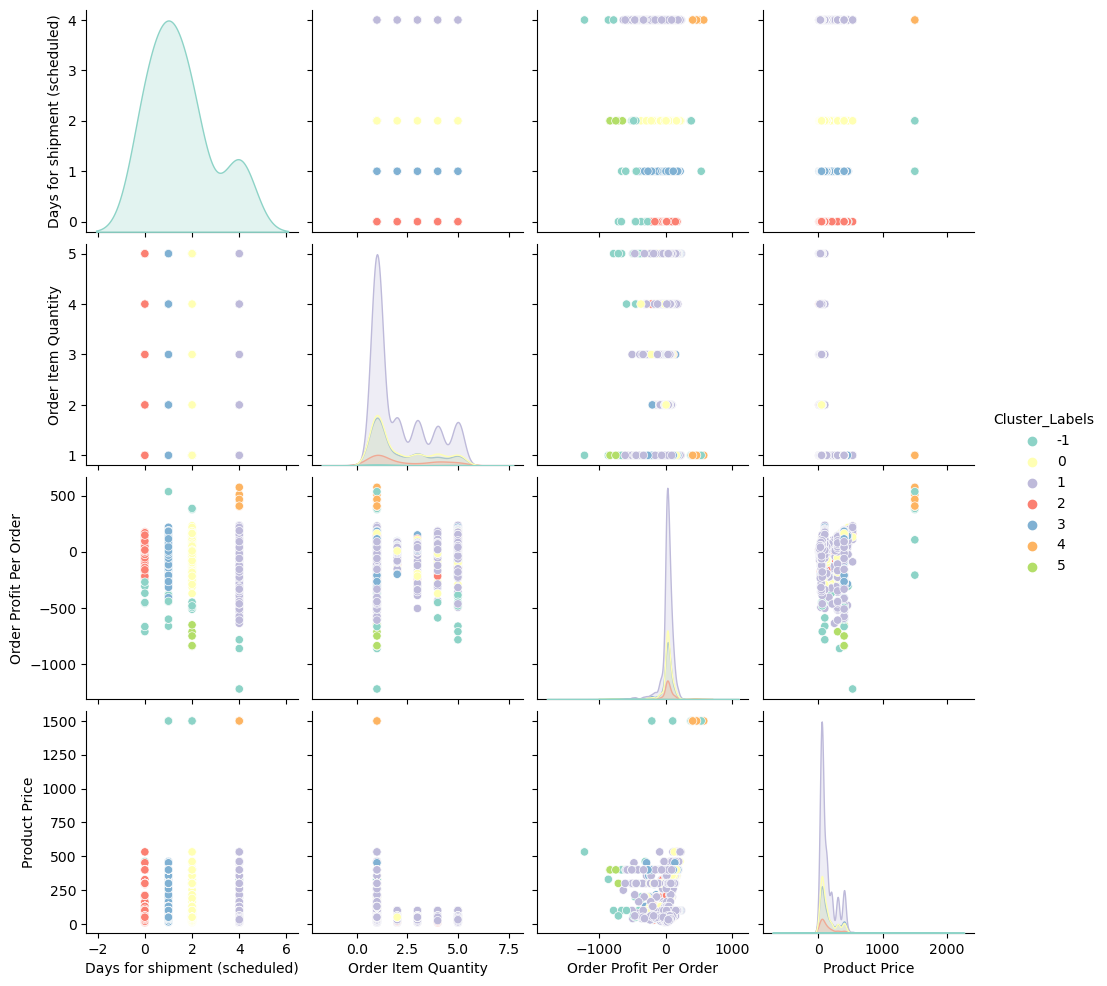

In [100]:
# scatter plot for numeric features
sns.pairplot(X_with_labels, hue='Cluster_Labels', palette='Set3')
plt.show()


### Agglomerative Clustering

In [101]:
X = data

# define preprocessing steps for numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# model pipeline
hierarchical = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('AgglomerativeClustering', AgglomerativeClustering(n_clusters=8))
])

hierarchical.fit(X)

# retrieve cluster labels from the AgglomerativeClustering estimator
cluster_labels = hierarchical.named_steps['AgglomerativeClustering'].labels_

# combine cluster labels with original data
X_with_labels = X.copy()
X_with_labels['Cluster_Labels'] = cluster_labels

# define a function to calculate mode for categorical variables and mean for numerical variables
def mode_and_mean(group):
    result = {}
    for column in group.columns:
        if group[column].dtype == 'object':
            result[column + '_mode'] = group[column].mode().iloc[0]
        else:
            result[column] = group[column].mean()
    return pd.Series(result)

# summarize each cluster
cluster_summary = X_with_labels.groupby('Cluster_Labels').apply(mode_and_mean)

print(cluster_summary)


                Days for shipment (scheduled)  Order Item Quantity  \
Cluster_Labels                                                       
0                                    1.299866             1.262383   
1                                    4.000000             1.587900   
2                                    4.000000             1.000000   
3                                    2.963158             2.231579   
4                                    1.341865             3.994516   
5                                    4.000000             4.518047   
6                                    3.090909             1.000000   
7                                    1.326241             1.000000   

                Order Profit Per Order  Product Price Shipping Mode_mode  \
Cluster_Labels                                                             
0                            18.050348     106.954474       Second Class   
1                            17.894007      93.810486     Standard Clas

#### Visualize Agglomerative Clustering

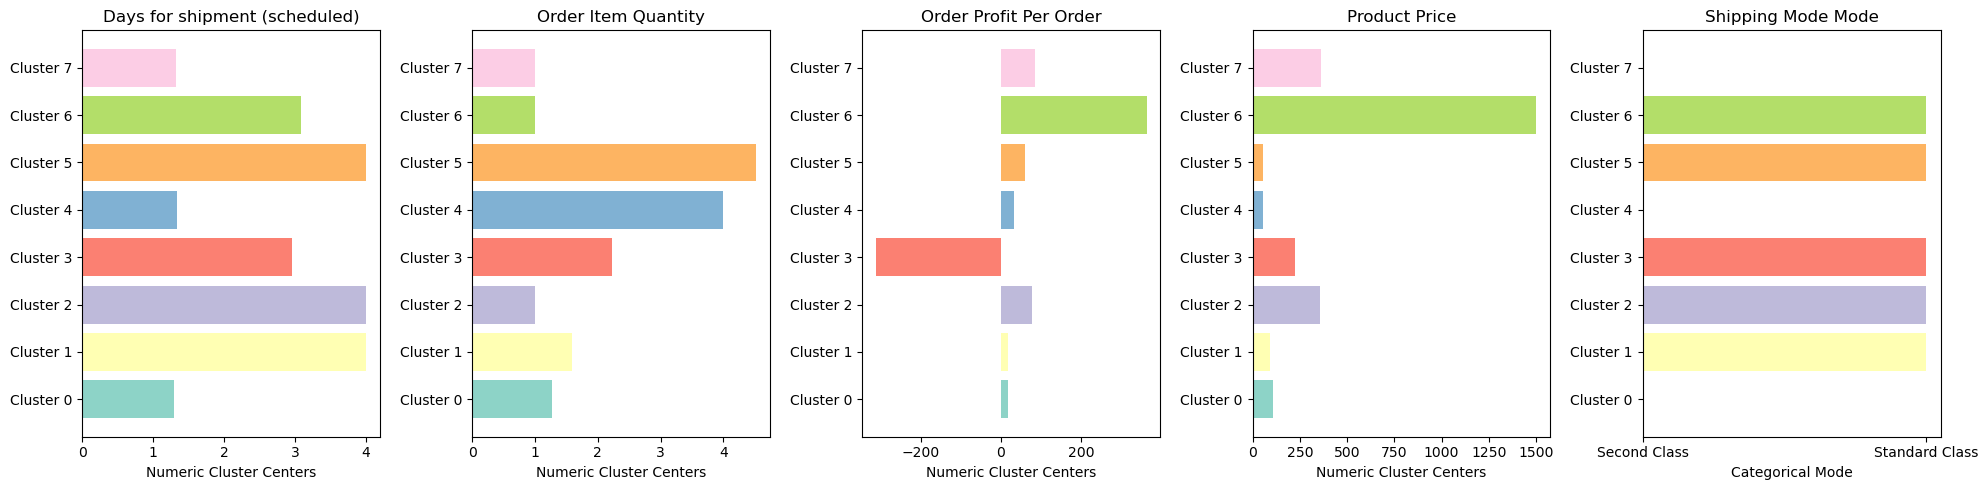

In [102]:
# define a color palette with different colors for each cluster
colors = plt.cm.Set3(np.arange(len(cluster_summary)))

# define the number of rows and columns for subplots
n_rows = 1
n_cols = len(numeric_features) + len(categorical_features)

# set up the subplot grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5))

for i, feature in enumerate(numeric_features):
    for j in range(len(cluster_summary)):
        axes[i].barh(j, cluster_summary[feature][j], color=colors[j], label=f'Cluster {j}')
    axes[i].set_yticks(range(len(cluster_summary)))
    axes[i].set_yticklabels([f'Cluster {j}' for j in range(len(cluster_summary))])
    axes[i].set_xlabel('Numeric Cluster Centers')
    axes[i].set_title(feature)

for i, feature in enumerate(categorical_features):
    offset = len(numeric_features)
    for j in range(len(cluster_summary)):
        mode = cluster_summary[f'{feature}_mode'][j]
        axes[i + offset].barh(j, mode, color=colors[j], label=f'Cluster {j}')
    axes[i + offset].set_yticks(range(len(cluster_summary)))
    axes[i + offset].set_yticklabels([f'Cluster {j}' for j in range(len(cluster_summary))])
    axes[i + offset].set_xlabel('Categorical Mode')
    axes[i + offset].set_title(f'{feature} Mode')

plt.tight_layout()
plt.show()
